# Summary

This analysis will use tree models to investigate which factors lead to movies earning high ratings on IMDb. The dataset contains 860 movies, web-scraped from the [New York Times list of 1000 best movies](http://www.nytimes.com/ref/movies/1000best.html). I then queried from the [Open Movie Database](http://omdbapi.com/)  for details such as directors, actors, release year, genre, runtime, a brief plot synopsis, and IMDb rating. I used sklearn's CountVectorizer to extract the most common bigrams from plot summaries, genre descriptions, and director and actor lists, and selected relevant features for a decision tree using recursive feature elimination.

In [1]:
# Imports at the top
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold, train_test_split, cross_val_score
from sklearn.feature_selection import RFECV, SelectKBest, f_regression
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor

/Users/teresaborcuch/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Data Selection and Cleaning
Originally, I considered utilizing [IMDb's top 250 movies](http://www.imdb.com/chart/top) for analysis, but realized that 250 titles wasn't quite enough, and that these were all relatively high-ranking titles anyways. In order to broaden the range of ratings I could train a model on, I needed more titles, and a wider range of stars. I found the NYT list, and scraped the titles using the Beautiful Soup library. I then got all movie details from the OMDB API, and created a Pandas DataFrame. The awards, actors, directors, and genres columns are lists within each cell, making it difficult to extract features. So far, the only thing I did was to create a 'won_Oscar' column containing a 1 if the awards column contained the phrase "won -- Oscar" and a 0 if it didn't, and drop any titles without an IMDb rating (leaving 860 titles to work with). Everything else is in its original format and will require some cleaning. (Here imported from csv.)

In [2]:
movies = pd.read_csv('/Users/teresaborcuch/Desktop/movies.csv')
del movies['Unnamed: 0']

In [3]:
movies.head()

,Actors,Awards,Country,Director,Genre,Plot,Rated,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes,won_Oscar
0,"Henri Marchand, Raymond Cordy, Rolla France, P...",Nominated for 1 Oscar. Another 3 wins.,France,René Clair,"Comedy, Musical","Seeking better life, two convicts escape from ...",APPROVED,97.0,À Nous la Liberté,movie,René Clair (story and screenplay),1931,tt0022599,7.7,3102,0
1,"Jack Nicholson, Kathy Bates, Hope Davis, Dermo...",Nominated for 2 Oscars. Another 24 wins & 68 n...,USA,Alexander Payne,"Comedy, Drama",A man upon retirement embarks on a journey to ...,R,125.0,About Schmidt,movie,"Louis Begley (novel), Alexander Payne (screenp...",2002,tt0257360,7.2,109332,0
2,"Paul Newman, Sally Field, Bob Balaban, Melinda...",Nominated for 3 Oscars. Another 3 wins & 5 nom...,USA,Sydney Pollack,"Drama, Romance, Thriller",When a prosecutor leaks a false story that a l...,PG,116.0,Absence of Malice,movie,Kurt Luedtke,1981,tt0081974,6.9,9474,0
3,"Elias Koteas, Arsinée Khanjian, Maury Chaykin,...",5 wins & 2 nominations.,Canada,Atom Egoyan,"Comedy, Drama",A reflection about what makes everyone's life ...,R,102.0,The Adjuster,movie,Atom Egoyan,1991,tt0101273,6.8,2575,0
4,"Errol Flynn, Olivia de Havilland, Basil Rathbo...",Won 3 Oscars. Another 2 wins & 2 nominations.,USA,"Michael Curtiz, William Keighley","Action, Adventure, Romance",When Prince John and the Norman Lords begin op...,PG,102.0,The Adventures of Robin Hood,movie,Norman Reilly Raine (original screenplay: base...,1938,tt0029843,8.0,39439,1


In [4]:
# Drop all entries without a runtime and reindex
# Movies without an imdb rating have already been dropped
movies = movies.dropna(subset = ['Runtime'])
movies = movies.reset_index(drop = True)

In [5]:
# Make relevant features into strings
cols = ['Actors','Country','Director','Genre','Plot','Title','Writer']
for col in cols:
    movies[col] = movies[col].astype(str)

In [6]:
# Make year an integer
clean_years = []
for year in movies['Year']:
    clean_year = int(year.replace('\xe2\x80\x93','').replace('2017','').replace('19851989','1985').replace('19721983','1972').replace('19671968','1967'))
    clean_years.append(clean_year)
movies['Year'] = clean_years

In [7]:
# make imdb Votes an int
votes = []
for vote in movies['imdbVotes']:
    str_vote = int(str(vote).replace(',',''))
    votes.append(str_vote)

In [8]:
# put Runtime in minutes
runtimes = []
for i, row in movies.iterrows():
    runtime = row[7]
    try:
        runtime = int(runtime.replace(' min', ''))
    except AttributeError:
        pass
    runtimes.append(runtime)

movies['Runtime'] = runtimes

# Exploratory Data Analysis
Here, I'll plot the distributions of all the numerical variables in the dataset. It seems year is just about normally distributed, runtime and IMDb votes skew right, and IMDb rating skews left.

In [39]:
movies['imdbRating'].describe()

count    860.000000
mean       7.568605
std        0.591217
min        4.200000
25%        7.300000
50%        7.600000
75%        8.000000
max        9.200000
Name: imdbRating, dtype: float64

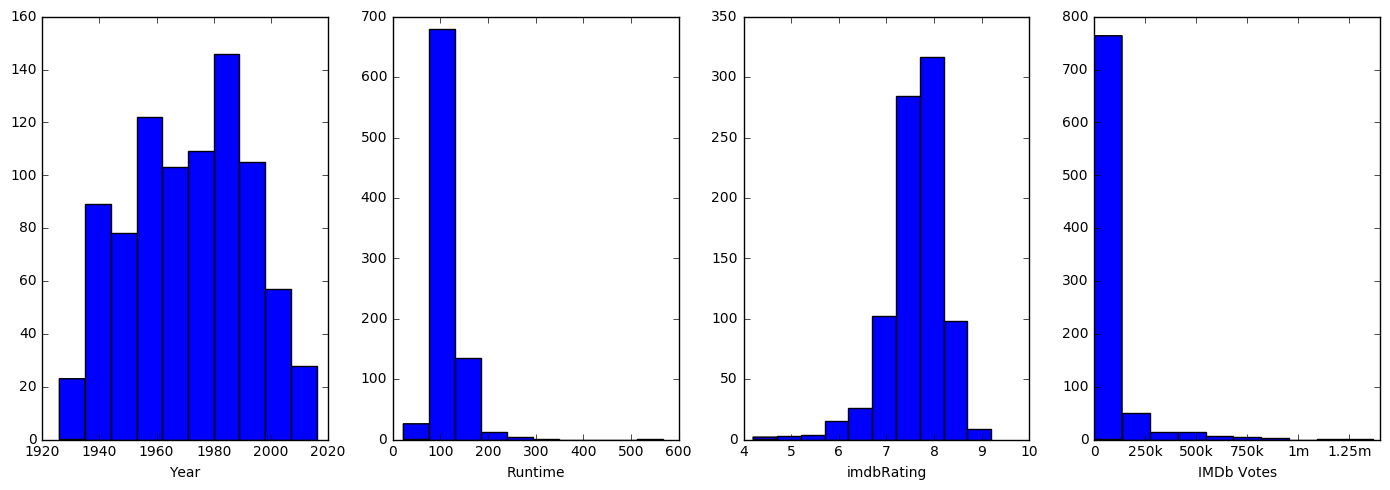

In [37]:
int_cols = ['Year','Runtime','imdbRating']

fig = plt.figure(figsize = (14,5))
count = 1
for col in int_cols:
    ax = fig.add_subplot(1,4,count)
    ax.hist(movies[col])
    ax.set_xlabel(col)

    count +=1
ax = fig.add_subplot(1,4,4)
ax.hist(movies['imdbVotes'])
ax.set_xlabel('IMDb Votes')
ax.set_xticks(range(0,1500000,250000))
ax.set_xticklabels(['0','250k','500k','750k','1m','1.25m'])
plt.tight_layout()
plt.show()

# Natural Language Processing

Since each movie comes with lists of actors, directors and genre classifications, as well as a brief plot synopsis, I'll mine this free-form text data to extract frequently used bigrams.

In [40]:
# combine hyphenated genres into one word
genres = []
for genre in movies['Genre']:
    genre = genre.replace('Sci-Fi','SciFi').replace('Film-Noir','FilmNoir')
    genres.append(genre)
movies['Genre'] = genres

In [41]:
# vectorize 1-grams and 2-grams for genre
gen_vec = CountVectorizer(ngram_range = (1,2), max_features = 20, strip_accents = 'ascii')
gen_vec.fit(movies['Genre'])
gen_bigrams = pd.DataFrame(gen_vec.transform(movies['Genre']).todense(),
                      columns = gen_vec.get_feature_names())

In [42]:
# Look at top 20 genre bigrams
gen_bigrams.sum(axis=0).sort_values(ascending = False).head(20)

drama              650
comedy             251
romance            229
drama romance      153
crime              144
comedy drama       127
crime drama        103
thriller            77
war                 74
adventure           65
biography           64
mystery             54
history             49
action              48
biography drama     47
drama history       45
drama war           42
musical             32
fantasy             29
comedy romance      29
dtype: int64

In [43]:
# vectorize 2-grams for plot
plot_vec = CountVectorizer(ngram_range=(2,2), stop_words = 'english', max_features = 23, strip_accents = 'ascii')
plot_vec.fit(movies['Plot'])
plot_bigrams = pd.DataFrame(plot_vec.transform(movies['Plot']).todense(),
                      columns = plot_vec.get_feature_names())

In [44]:
# selectively eliminate some meaningless ones
del plot_bigrams['war ii']
del plot_bigrams['york city']
del plot_bigrams['fall love']

In [45]:
# Look at top 20 plot bigrams
plot_bigrams.sum(axis=0).sort_values(ascending = False).head(20)

world war            32
new york             24
falls love           20
year old             17
young man            13
young woman          12
small town           11
vietnam war           8
high school           7
middle aged           7
civil war             7
los angeles           6
private detective     6
old friend            5
san francisco         5
married couple        5
small time            5
teenage girl          5
falling love          5
return home           4
dtype: int64

These are the top 20 2-words plot themes to appear in the NYT top 1000 movies. Wars, youth, love, marriage, and cities seem to be common themes.

In [46]:
# Make 2-3-grams for actors
act_vec = CountVectorizer(ngram_range=(2,3), max_features = 22, strip_accents = 'ascii')
act_vec.fit(movies['Actors'])
actor_bigrams = pd.DataFrame(act_vec.transform(movies['Actors']).todense(),
                      columns = act_vec.get_feature_names())

In [47]:
# eliminate duplicates for actors
del actor_bigrams['de niro']
del actor_bigrams['robert de']

In [48]:
# Look at top 20 actor bigrams
actor_bigrams.sum(axis=0).sort_values(ascending = False)

burt lancaster       11
cary grant           10
james stewart         9
dustin hoffman        9
gary cooper           9
john wayne            9
humphrey bogart       9
william holden        8
jack nicholson        8
james mason           8
marlon brando         8
paul newman           8
bette davis           8
robert de niro        7
jean arthur           7
jean pierre           7
henry fonda           7
harvey keitel         7
katharine hepburn     7
kirk douglas          7
dtype: int64

These are the most frequently occuring 20 actors to appear in the NYT top 1000 movies.

In [49]:
# Make 2-3-grams for directors
dir_vec = CountVectorizer(ngram_range=(2,3), strip_accents = 'ascii')
dir_vec.fit(movies['Actors'])
director_bigrams = pd.DataFrame(dir_vec.transform(movies['Director']).todense(),
                      columns = dir_vec.get_feature_names())

In [50]:
del director_bigrams['vittorio de']
del director_bigrams['de sica']

In [51]:
# Look at top 10 director bigrams
director_bigrams.sum(axis=0).sort_values(ascending = False).head(10)

francois truffaut    10
john huston           9
woody allen           7
vittorio de sica      5
sydney pollack        4
otto preminger        4
fritz lang            3
clint eastwood        3
kenneth branagh       3
jules dassin          3
dtype: int64

In [52]:
director_bigrams = director_bigrams[['francois truffaut', 'john huston', 'woody allen', 'vittorio de sica',
                                    'sydney pollack', 'otto preminger', 'kenneth branagh', 'jules dassin', 
                                    'fritz lang', 'clint eastwood']]

In [53]:
# combine all bigrams into one dataframe
bigrams = pd.concat([actor_bigrams, plot_bigrams, gen_bigrams], axis = 1)

# Assembling Target and Predictor Matrices

In [54]:
# scale year, imdb votes and runtime
data = movies[['Runtime','Year','imdbVotes']]
scaled_data = preprocessing.scale(data)
scaled_data = pd.DataFrame(scaled_data, columns = data.columns)

In [55]:
# combine the numerical variables with the won_Oscar column
features = pd.concat([scaled_data, movies['won_Oscar']], axis = 1)
features.shape

(860, 4)

In [56]:
# combine with bigrams
X = pd.concat([features, bigrams], axis = 1)
X.shape

(860, 64)

In [57]:
y = movies['imdbRating']

# Feature Selection
To narrow down the number of features to consider when building a tree, I'll use cross-validated recursive feature elimination.

In [58]:
# RFECV feature selection
rfecv = RFECV(estimator = DecisionTreeRegressor(), cv = 5, scoring = 'mean_squared_error')
rfecv.fit(X,y)
rfecv_cols = X.columns[rfecv.support_]

In [65]:
# These are the 13 features selected
for x in rfecv_cols:
    print x

Runtime
Year
imdbVotes
won_Oscar
katharine hepburn
action
comedy
crime drama
drama
drama romance
musical
mystery
thriller


In [66]:
X_sel = X[rfecv_cols]

# Decision Trees
Here, I'll build several types of trees on a training set, use then to predict IMDb rating on a test set, and compare mean squared error to see which has the best fit.

In [67]:
# make train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size = 0.3)

In [68]:
# fit basic decision tree
scores = {}
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
mse = np.mean(cross_val_score(dt, X_test, y_test, cv = 10, scoring = "mean_squared_error"))
scores['dtr'] = abs(mse)
print "MSE: ", mse
print "R2: ",  np.mean(cross_val_score(dt, X_test, y_test, cv = 10))

MSE:  -0.284067692308
R2:  0.0431909899402


In [69]:
#fit a bagging tree
bdt = BaggingRegressor()
bdt.fit(X_train, y_train)
mse = np.mean(cross_val_score(bdt, X_test, y_test, cv = 10, scoring = 'mean_squared_error'))
scores['bdt'] = abs(mse)
print "MSE: ", mse
print "R2: ",  np.mean(cross_val_score(bdt, X_test, y_test, cv = 10))

MSE:  -0.194712846154
R2:  0.410342918371


In [70]:
# try a gridsearch for bagging tree
params = {'n_estimators': [5,10,25,100],
          'max_samples': [0.25,0.5,0.75,1.0],
          'max_features': [0.25,0.5,0.75,1.0]}

gsbt = GridSearchCV(BaggingRegressor(),
                    params, n_jobs=-1,
                    cv=KFold(len(y_train), n_folds=3, shuffle=True),
                   scoring = 'mean_squared_error')
gsbt.fit(X_train, y_train)
mse = np.mean(cross_val_score(gsbt.best_estimator_, X_test, y_test, cv = 10, scoring = 'mean_squared_error'))
scores['gsbt'] = abs(mse)
print "MSE: ", mse
print "R2: ", np.mean(cross_val_score(gsbt.best_estimator_, X_test, y_test, cv = 10))

MSE:  -0.203966795077
R2:  0.428464907877


In [71]:
# fit a gradient boosting regressor
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
mse = np.mean(cross_val_score(gbr, X_test, y_test, cv = 10,scoring = 'mean_squared_error'))
scores['gbr'] = abs(mse)
print "MSE: ", mse
print "R2: ", np.mean(cross_val_score(gbr, X_test, y_test, cv = 10))

MSE:  -0.163314810746
R2:  0.505127595883


In [72]:
# try a gridsearch for gradient boosting regressor
params = {'n_estimators': [5,10,25,100,200,500],
          'loss': ['ls','lad','huber','quantile'],
          'max_depth': [None, 3, 5, 10],
          'max_features': [0.25,0.5,0.75,1.0]}

gsgbr = GridSearchCV(GradientBoostingRegressor(),
                    params, n_jobs=-1,
                    cv=KFold(len(y_train), n_folds=3, shuffle=True),
                   scoring = 'mean_squared_error')
gsgbr.fit(X_train, y_train)
mse = np.mean(cross_val_score(gsgbr.best_estimator_, X_test, y_test, cv = 10, scoring = 'mean_squared_error'))
scores['gsgbr'] = abs(mse)
print "MSE: ", mse
print "R2: ", np.mean(cross_val_score(gsgbr.best_estimator_, X_test, y_test, cv = 10))

MSE:  -0.166590262918
R2:  0.500032505244


In [73]:
# adaboost regressor
abdt = AdaBoostRegressor()
abdt.fit(X_train, y_train)
mse = np.mean(cross_val_score(abdt, X_test, y_test, cv = 10, scoring = 'mean_squared_error'))
scores['abdt'] = abs(mse)
print "MSE: ", mse
print "R2: ", np.mean(cross_val_score(abdt, X_test, y_test, cv = 10))

MSE:  -0.238394550709
R2:  0.29080789357


In [74]:
# gridsearch adaboost
params = {'n_estimators': [5,10,25,100,200,500],
          'loss': ['linear','square','exponential'],
          'learning_rate': [0.25,0.5,0.75,1.0]}

gsab = GridSearchCV(AdaBoostRegressor(),
                    params, n_jobs=-1,
                    cv=KFold(len(y_train), n_folds=3, shuffle=True),
                   scoring = 'mean_squared_error')
gsab.fit(X_train, y_train)
mse = np.mean(cross_val_score(gsab.best_estimator_, X_test, y_test, cv = 10, scoring = 'mean_squared_error'))
scores['gsab'] = abs(mse)
print "MSE: ", mse
print "R2: ", np.mean(cross_val_score(gsab.best_estimator_, X_test, y_test, cv = 10))

MSE:  -0.231363849408
R2:  0.250934954671


In [75]:
# random forests
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
mse = np.mean(cross_val_score(rfr, X_test, y_test, cv = 10, scoring = 'mean_squared_error'))
scores['rfr'] = abs(mse)
print "MSE: ", mse
print "R2: ", np.mean(cross_val_score(rfr, X_test, y_test, cv = 10))

MSE:  -0.182543569231
R2:  0.351731764199


In [76]:
# gridsearch random forests
params = {'n_estimators': [5,10,25,100,200,500],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3],
          'bootstrap': [True, False]}

gsrf = GridSearchCV(RandomForestRegressor(),
                    params, n_jobs=-1,
                    cv=KFold(len(y_train), n_folds=3, shuffle=True),
                   scoring = 'mean_squared_error')
gsrf.fit(X_train, y_train)
mse = np.mean(cross_val_score(gsrf.best_estimator_, X_test, y_test, cv = 10, scoring = 'mean_squared_error'))
scores['gsrf'] = abs(mse)
print "MSE: ", mse
print "R2: ", np.mean(cross_val_score(gsrf.best_estimator_, X_test, y_test, cv = 10))

MSE:  -0.204349475688
R2:  0.415766355466


In [77]:
scores

{'abdt': 0.23839455070852944,
 'bdt': 0.1947128461538461,
 'dtr': 0.2840676923076923,
 'gbr': 0.16331481074649212,
 'gsab': 0.23136384940809435,
 'gsbt': 0.203966795076923,
 'gsgbr': 0.16659026291796281,
 'gsrf': 0.20434947568844838,
 'rfr': 0.18254356923076909}

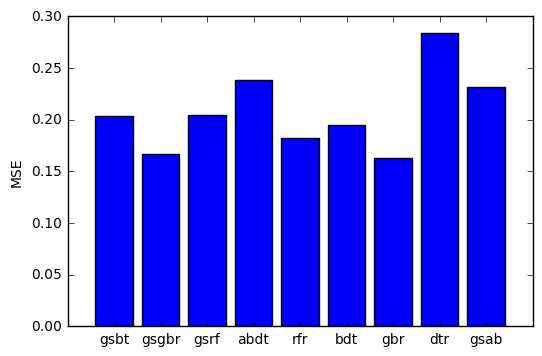

In [114]:
plt.bar(range(len(scores)), scores.values(), align='center')
plt.xticks(range(len(scores)), scores.keys())
plt.ylabel('MSE')
plt.show()

This graph displays the mean squared error for each model. All ensemble methods improved score from the basic decision tree regression (dtr). Gradient boosting regression trees (gsgbr and gbr) performed best, predicting IMDb rating score within 0.4 stars.

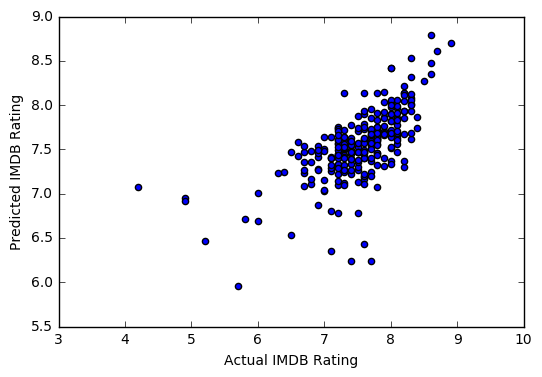

In [79]:
# compare predictions to actual values for gridsearch bagging tree
y_pred = gsgbr.best_estimator_.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel("Actual IMDB Rating")
plt.ylabel("Predicted IMDB Rating")
plt.show()

In [80]:
# which features were most important in the gridsearch gradient boosting regression
features = pd.DataFrame(columns = ['feature','importance'])
features['importance'] = gsgbr.best_estimator_.feature_importances_
features['feature']= rfecv_cols
features.sort_values('importance', ascending = False)

,feature,importance
2,imdbVotes,0.317943
1,Year,0.297993
0,Runtime,0.228371
5,action,0.034325
11,mystery,0.023441
8,drama,0.019607
9,drama romance,0.015798
4,katharine hepburn,0.014403
10,musical,0.012535
6,comedy,0.012212


The most important feature in the best-fitting model was IMDb votes, followed by year of release, and runtime. From all the initial features observed for each movie, these type of meta-features were selected above plot summaries and most actors or directors (with the exception of Katharine Hepburn), and they hold more importance in this model as well.